In [19]:
"""
# Life Cycle Analysis (LCA) Tool Example

This script demonstrates the functionality of the LCA tool for analyzing environmental impacts 
of products throughout their life cycle.
"""

'\n# Life Cycle Analysis (LCA) Tool Example\n\nThis script demonstrates the functionality of the LCA tool for analyzing environmental impacts \nof products throughout their life cycle.\n'

## 1. Setup and Data Loading

First, let's import the necessary modules and load our data.

In [111]:
import sys

import pandas as pd
import matplotlib.pyplot as plt
from src.data_input import DataInput
from src.calculations import LCACalculator
from src.visualization import LCAVisualizer


In [113]:
import sys
import os

# Add '../src' directory to Python path
module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)


import numpy as np
from data_input import DataInput  # now it should work

def notebook_validate_data(self, data):
    required_columns = [
        'product_id', 'product_name', 'life_cycle_stage', 'material_type',
        'quantity_kg', 'energy_consumption_kwh', 'transport_distance_km',
        'transport_mode', 'waste_generated_kg',
        'recycling_rate', 'landfill_rate', 'incineration_rate',
        'carbon_footprint_kg_co2e', 'water_usage_liters'
    ]

    for col in required_columns:
        if col not in data.columns:
            print(f"Missing column: {col}")
            return False

    for i, row in data.iterrows():
        try:
            float(row['quantity_kg'])
            float(row['energy_consumption_kwh'])
            float(row['transport_distance_km'])
            float(row['waste_generated_kg'])
        except ValueError:
            print(f"Invalid numeric value in row {i}")
            return False

        total_rate = row['recycling_rate'] + row['landfill_rate'] + row['incineration_rate']
        if not np.isclose(total_rate, 1.0, atol=0.01):
            print(f"Rates in row {i} do not sum to 1.0: {total_rate}")
            return False

    return True

# Patch the method
DataInput.validate_data = notebook_validate_data

print("✅ validate_data() method overridden in notebook.")

✅ validate_data() method overridden in notebook.


### Load Product Data
Load the sample product data from CSV file.

In [116]:
# Initialize data input handler
data_input = DataInput()

# Load product data
product_data = data_input.read_data('../data/raw/sample_data.csv')
print("Product Data Shape:", product_data.shape)
product_data.head()

Product Data Shape: (60, 14)


,product_id,product_name,life_cycle_stage,material_type,quantity_kg,energy_consumption_kwh,transport_distance_km,transport_mode,waste_generated_kg,recycling_rate,landfill_rate,incineration_rate,carbon_footprint_kg_co2e,water_usage_liters
0,P001,Reinforced Concrete,Manufacturing,Concrete,2500.0,120.0,50,Truck,125.0,0.1,0.80,0.10,350.0,150.0
1,P001,Reinforced Concrete,Transportation,Concrete,2500.0,20.0,100,Truck,0.0,0.0,0.00,0.00,75.0,0.0
2,P001,Reinforced Concrete,End-of-Life,Concrete,2500.0,50.0,30,Truck,2500.0,0.1,0.80,0.10,200.0,50.0
3,P002,Structural Steel Beam,Manufacturing,Steel,500.0,300.0,200,Truck,25.0,0.9,0.05,0.05,450.0,200.0
4,P002,Structural Steel Beam,Transportation,Steel,500.0,40.0,150,Truck,0.0,0.0,0.00,0.00,100.0,0.0


In [118]:
# Initialize data input handler
data_input = DataInput()

# Load product data
product_data = data_input.read_data('../data/raw/sample_data.csv')
print("Product Data Shape:", product_data.shape)
print(list(impact_factors.keys()))
product_data.head()

# Validation
# --- Data validation & quick-fix helper ------------------------------------
from IPython.display import Markdown
import pandas as pd

di = data_input          # aynı DataInput örneğini kullan
rename_map = {
    'Energy_kWh': 'energy_consumption_kwh',
    'Carbon_kg': 'carbon_footprint_kg_co2e',
    'Water_L':   'water_usage_liters',
}
product_data.rename(columns=rename_map, inplace=True)

missing = [c for c in di.required_columns if c not in product_data.columns]
if missing:
    raise ValueError(f"Missing required columns → {missing}")

num_cols = [
    'quantity_kg', 'energy_consumption_kwh',
    'waste_generated_kg', 'carbon_footprint_kg_co2e',
    'water_usage_liters'
]
for col in num_cols:
    product_data[col] = (
        product_data[col]
        .astype(str)
        .str.replace(',', '')          # 1,200  -> 1200
        .str.extract(r'([-+]?[0-9]*\.?[0-9]+)')[0]   # "12 kg" -> "12"
        .astype(float)
    )

rate_cols = ['recycling_rate', 'landfill_rate', 'incineration_rate']

product_data[rate_cols] = product_data[rate_cols].apply(
    lambda s: s / 100 if s.max() > 1 else s
)

rate_sum = product_data[rate_cols].sum(axis=1)
imbalanced = (rate_sum - 1).abs() > 1e-3
product_data.loc[imbalanced, 'landfill_rate'] = (
    1 - product_data.loc[imbalanced, ['recycling_rate', 'incineration_rate']].sum(axis=1)
)

assert di.validate_data(product_data), (
    "❌ Data validation still failing – manual check required."
)

Markdown("✅ **Data validation passed & common issues auto-fixed.**")




Product Data Shape: (60, 14)
['steel', 'aluminum', 'plastic', 'paper', 'concrete', 'wood', 'clay', 'glass', 'copper', 'mineral_wool', 'cement']


✅ **Data validation passed & common issues auto-fixed.**

### Load Impact Factors
Load the environmental impact factors from JSON file.

In [121]:
# Load impact factors
impact_factors = data_input.read_impact_factors('../data/raw/impact_factors.json')
print("Available Materials:", list(impact_factors.keys()))
print("\nImpact Factors for Steel:")
pd.DataFrame(impact_factors['steel'])

Available Materials: ['steel', 'aluminum', 'plastic', 'paper', 'concrete', 'wood', 'clay', 'glass', 'copper', 'mineral_wool', 'cement']

Impact Factors for Steel:


,manufacturing,transportation,disposal
carbon_impact,1.8,0.5,0.1
carbon_unit,kg CO2e,kg CO2e,kg CO2e
energy_impact,20,5,1
energy_unit,MJ,MJ,MJ
water_impact,150,30,10
water_unit,L,L,L


## 2. Impact Calculations

Calculate environmental impacts using the LCACalculator.

In [124]:
# Initialize calculator
calculator = LCACalculator(impact_factors_path='../data/raw/impact_factors.json')

# Calculate impacts
impacts = calculator.calculate_impacts(product_data)
print("Calculated Impacts Shape:", impacts.shape)
impacts.head()

Calculated Impacts Shape: (60, 14)


,product_id,product_name,life_cycle_stage,material_type,quantity_kg,energy_consumption_kwh,transport_distance_km,waste_generated_kg,carbon_impact,energy_impact,water_impact,recycling_rate,landfill_rate,incineration_rate
0,P001,Reinforced Concrete,manufacturing,concrete,2500.0,120.0,50,125.0,700.0,3870.0,150150.0,0.1,0.80,0.10
1,P001,Reinforced Concrete,transportation,concrete,2500.0,20.0,100,0.0,150.0,770.0,0.0,0.0,1.00,0.00
2,P001,Reinforced Concrete,end-of-life,concrete,2500.0,50.0,30,2500.0,200.0,50.0,50.0,0.1,0.80,0.10
3,P002,Structural Steel Beam,manufacturing,steel,500.0,300.0,200,25.0,1350.0,10300.0,75200.0,0.9,0.05,0.05
4,P002,Structural Steel Beam,transportation,steel,500.0,40.0,150,0.0,350.0,2540.0,15000.0,0.0,1.00,0.00


### Calculate Total Impacts
Aggregate impacts by product.

In [127]:
# --- Calculate & inspect total impacts -------------------------------------
# 'impacts' DataFrame'i bir üst hücrede oluşturulmuş olmalı
totals_df = calculator.calculate_total_impacts(impacts)
print("Total impacts by product:")
display(totals_df.head())

# --- Persist total-impact results ------------------------------------------
from pathlib import Path

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)   # create if missing

output_csv = RESULTS_DIR / "total_impact_results.csv"
totals_df.to_csv(output_csv, index=False)

print(f"💾 Total impacts written to: {output_csv.resolve()}")


Total impacts by product:


,product_id,product_name,carbon_impact,energy_impact,water_impact,waste_generated_kg
0,P001,Reinforced Concrete,1050.0,4690.0,150200.0,2625.00
1,P002,Structural Steel Beam,1850.0,12870.0,90230.0,525.00
2,P003,Engineered Wood Beam,300.0,1205.0,8100.0,105.00
3,P004,Clay Brick,11.0,72.0,112.0,2.75
4,P005,Glass Panel,800.0,3850.0,10115.0,52.50


💾 Total impacts written to: C:\Users\ygurm\CE49X-Spring25\labs\final_project\notebooks\results\total_impact_results.csv


## 3. Visualization

Create various visualizations using the LCAVisualizer.

### Impact Breakdown by Material Type

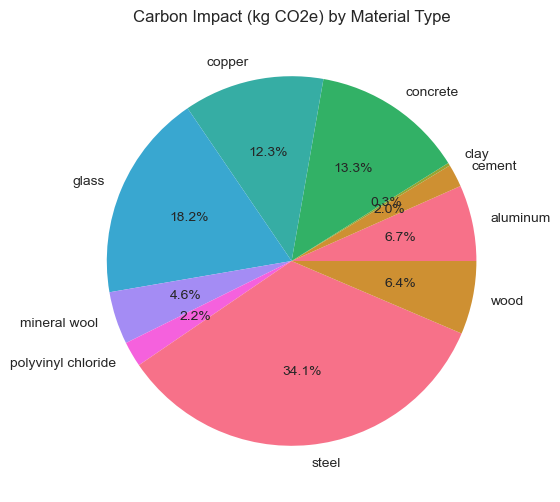

In [131]:
visualizer = LCAVisualizer()

# Plot carbon impact breakdown by material type
fig = visualizer.plot_impact_breakdown(impacts, 'carbon_impact', 'material_type')
plt.show()

### Life Cycle Impacts for a Specific Product

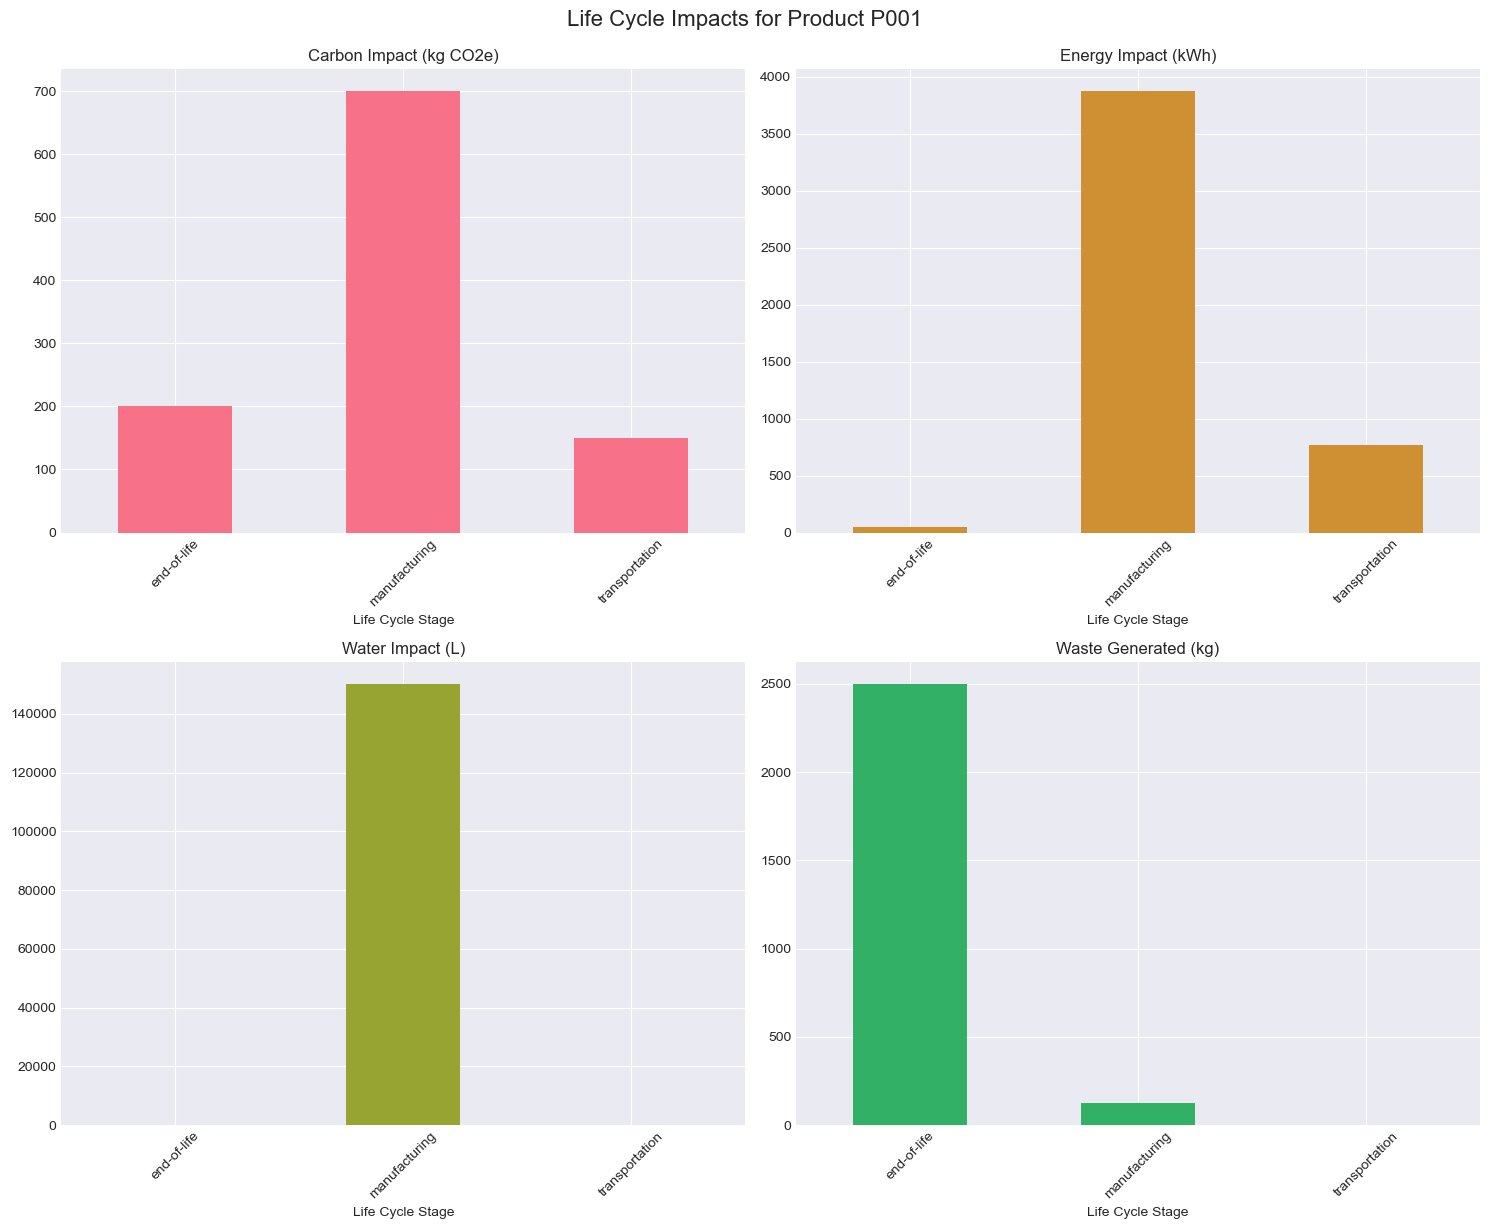

In [134]:
# Plot life cycle impacts for Product1
fig = visualizer.plot_life_cycle_impacts(impacts, 'P001')
plt.show()

### Product Comparison

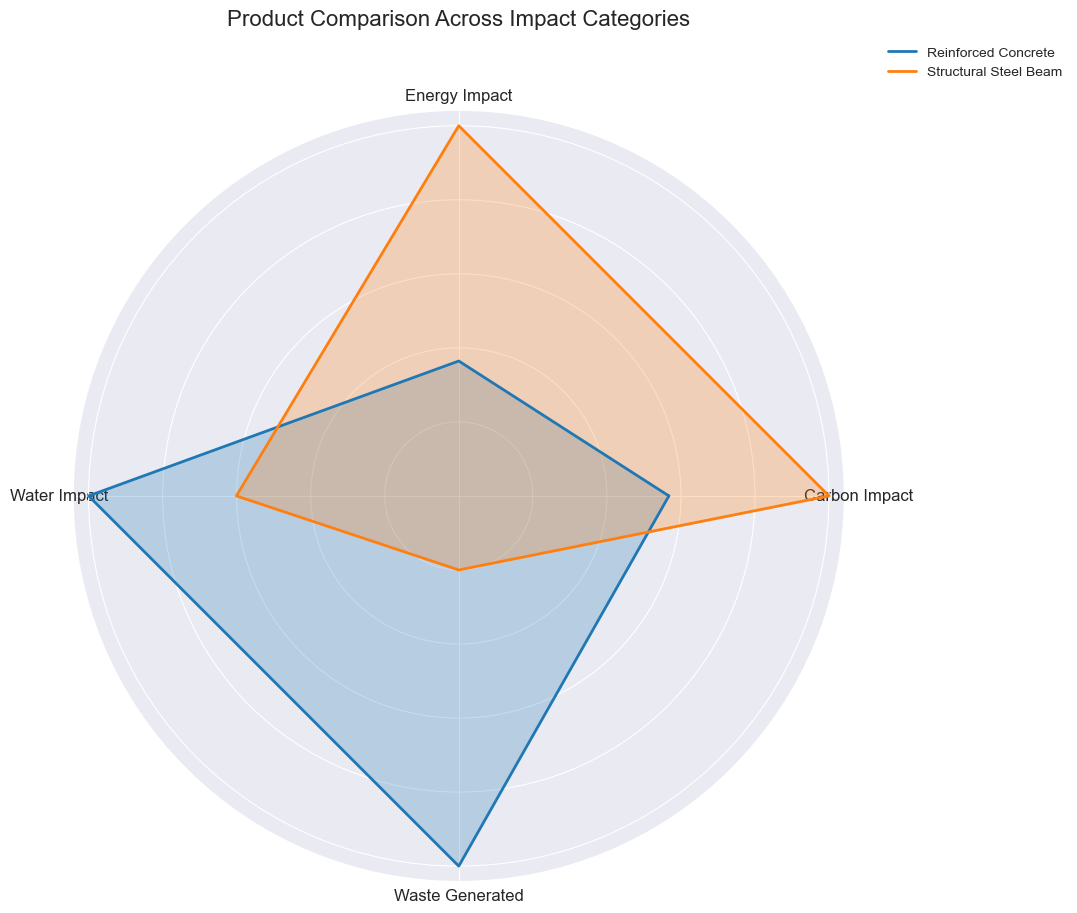

In [137]:
# Compare two products
fig = visualizer.plot_product_comparison(impacts, ['P001', 'P002'])
plt.show()

### End-of-Life Management

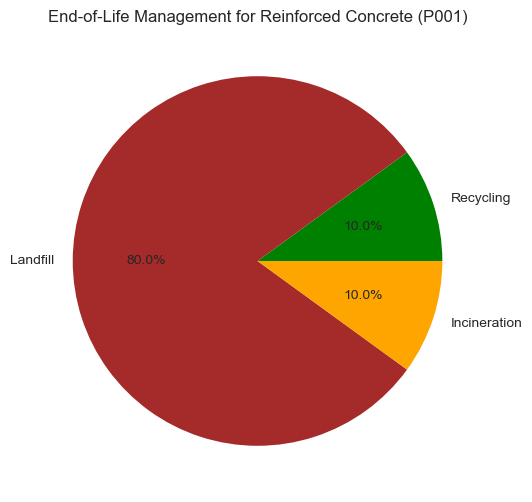

In [140]:
# Plot end-of-life breakdown for Product1
fig = visualizer.plot_end_of_life_breakdown(impacts, 'P001')
plt.show()

### Impact Category Correlations

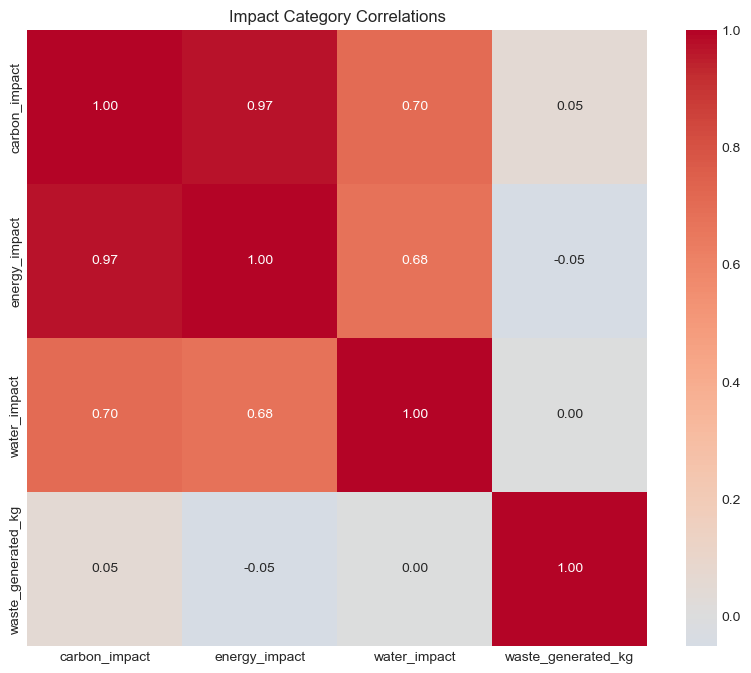

In [143]:
# Plot impact correlations
fig = visualizer.plot_impact_correlation(impacts)
plt.show()

## 4. Advanced Analysis

Perform more advanced analysis using the calculator's features.

### Normalize Impacts

In [147]:
# Normalize impacts for comparison
normalized_impacts = calculator.normalize_impacts(impacts)
print("Normalized Impacts:")
normalized_impacts.head()

Normalized Impacts:


,product_id,product_name,life_cycle_stage,material_type,quantity_kg,energy_consumption_kwh,transport_distance_km,waste_generated_kg,carbon_impact,energy_impact,water_impact,recycling_rate,landfill_rate,incineration_rate
0,P001,Reinforced Concrete,manufacturing,concrete,2500.0,120.0,50,125.0,0.518519,0.375728,1.000000,0.1,0.80,0.10
1,P001,Reinforced Concrete,transportation,concrete,2500.0,20.0,100,0.0,0.111111,0.074757,0.000000,0.0,1.00,0.00
2,P001,Reinforced Concrete,end-of-life,concrete,2500.0,50.0,30,2500.0,0.148148,0.004854,0.000333,0.1,0.80,0.10
3,P002,Structural Steel Beam,manufacturing,steel,500.0,300.0,200,25.0,1.000000,1.000000,0.500833,0.9,0.05,0.05
4,P002,Structural Steel Beam,transportation,steel,500.0,40.0,150,0.0,0.259259,0.246602,0.099900,0.0,1.00,0.00


### Compare Alternatives

In [150]:
# Compare alternative products
comparison = calculator.compare_alternatives(impacts, ['P001', 'P002'])
print("Product Comparison:")
comparison 

Product Comparison:


,product_id,product_name,life_cycle_stage,material_type,quantity_kg,energy_consumption_kwh,transport_distance_km,waste_generated_kg,carbon_impact,energy_impact,water_impact,recycling_rate,landfill_rate,incineration_rate,carbon_impact_relative,energy_impact_relative,water_impact_relative
0,P001,Reinforced Concrete,manufacturing,concrete,2500.0,120.0,50,125.0,700.0,3870.0,150150.0,0.1,0.80,0.10,366.666667,12800.000000,inf
1,P001,Reinforced Concrete,transportation,concrete,2500.0,20.0,100,0.0,150.0,770.0,0.0,0.0,1.00,0.00,0.000000,2466.666667,NaN
2,P001,Reinforced Concrete,end-of-life,concrete,2500.0,50.0,30,2500.0,200.0,50.0,50.0,0.1,0.80,0.10,33.333333,66.666667,inf
3,P002,Structural Steel Beam,manufacturing,steel,500.0,300.0,200,25.0,1350.0,10300.0,75200.0,0.9,0.05,0.05,800.000000,34233.333333,inf
4,P002,Structural Steel Beam,transportation,steel,500.0,40.0,150,0.0,350.0,2540.0,15000.0,0.0,1.00,0.00,133.333333,8366.666667,inf
5,P002,Structural Steel Beam,end-of-life,steel,500.0,30.0,40,500.0,150.0,30.0,30.0,0.9,0.05,0.05,0.000000,0.000000,inf


In [152]:
!pip install openpyxl

import os
import pandas as pd

# Create results directory if it doesn't exist
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

# Prepare file paths
excel_path = os.path.join(results_dir, 'LCA_outputs.xlsx')
csv_path = os.path.join(results_dir, 'summary_scores.csv')

# Create summary total score
summary = comparison.copy()
summary['total_score'] = (
    summary['carbon_impact'] + 
    summary['energy_impact'] + 
    summary['water_impact'] + 
    summary['waste_generated_kg']
)

# Save everything
try:
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        impacts.to_excel(writer, sheet_name='Calculated Impacts', index=False)
        normalized_impacts.to_excel(writer, sheet_name='Normalized Impacts', index=False)
        comparison.to_excel(writer, sheet_name='Product Comparison', index=False)
        summary.to_excel(writer, sheet_name='Summary Scores', index=False)

    summary[['product_id', 'product_name', 'total_score']].to_csv(csv_path, index=False)
    print(f"✅ Results saved to:\n- Excel: {excel_path}\n- CSV: {csv_path}")

except Exception as e:
    print(f"❌ Failed to save results: {e}")

✅ Results saved to:
- Excel: ../results\LCA_outputs.xlsx
- CSV: ../results\summary_scores.csv


In [153]:
# Create visualizer
visualizer = LCAVisualizer()

# 1. Impact Breakdown (carbon impact by material)
fig1 = visualizer.plot_impact_breakdown(impacts, 'carbon_impact', 'material_type')
fig1.savefig('../results/impact_breakdown.png', dpi=300)

# 2. Life Cycle Impacts for a product (e.g., P001)
fig2 = visualizer.plot_life_cycle_impacts(impacts, 'P001')
fig2.savefig('../results/life_cycle_impacts_P001.png', dpi=300)

# 3. Product Comparison Radar Chart (e.g., P001 vs P002)
fig3 = visualizer.plot_product_comparison(impacts, ['P001', 'P002'])
fig3.savefig('../results/product_comparison.png', dpi=300)

# 4. End-of-Life Breakdown (e.g., P001)
fig4 = visualizer.plot_end_of_life_breakdown(impacts, 'P001')
fig4.savefig('../results/end_of_life_P001.png', dpi=300)

# 5. Correlation Heatmap
fig5 = visualizer.plot_impact_correlation(impacts)
fig5.savefig('../results/impact_correlation.png', dpi=300)

plt.close('all')  # Close all figures after saving
print("✅ All visualizations saved to '../results/' folder as PNG files.")

✅ All visualizations saved to '../results/' folder as PNG files.


In [155]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

pdf_path = '../results/LCA_Report.pdf'

with PdfPages(pdf_path) as pdf:
    # Title Page
    fig_title = plt.figure(figsize=(11.69, 8.27))  # A4 landscape
    plt.text(0.5, 0.6, 'Life Cycle Assessment Report', fontsize=24, ha='center')
    plt.text(0.5, 0.5, 'Generated Automatically with Python', fontsize=14, ha='center')
    plt.axis('off')
    pdf.savefig(fig_title)
    plt.close()

    # Summary Table
    fig_summary, ax = plt.subplots(figsize=(11.69, 5))
    ax.axis('off')
    table_data = summary[['product_id', 'product_name', 'total_score']].round(2)
    table = ax.table(cellText=table_data.values,
                     colLabels=table_data.columns,
                     loc='center',
                     cellLoc='center')
    table.scale(1, 2)
    ax.set_title('Total Environmental Impact Scores by Product', fontsize=16, pad=20)
    pdf.savefig(fig_summary)
    plt.close()

    # Load and add each saved plot image
    image_paths = [
        '../results/impact_breakdown.png',
        '../results/life_cycle_impacts_P001.png',
        '../results/product_comparison.png',
        '../results/end_of_life_P001.png',
        '../results/impact_correlation.png'
    ]

    for path in image_paths:
        fig = plt.figure(figsize=(11.69, 8.27))  # A4 landscape
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')
        pdf.savefig(fig)
        plt.close()

print(f"✅ PDF report created at: {pdf_path}")

✅ PDF report created at: ../results/LCA_Report.pdf
